In [1]:
#import modules
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Dense,concatenate, Activation,Add, Dropout, MaxPooling2D, Conv2D, Flatten, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
#check gpu
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [3]:
comp_path = '../input/petfinder-pawpularity-score'
train_csv_path = '../input/petfinder-pawpularity-score/train.csv'
test_csv_path = '../input/petfinder-pawpularity-score/test.csv'

In [4]:
#read meta data
train_meta = pd.read_csv(train_csv_path)
train_meta.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [5]:
#function for make full path
def make_full_path_train(id):
    return os.path.join(comp_path, 'train', id+'.jpg')
train_meta['Id2'] = train_meta['Id'].apply(make_full_path_train)
train_meta.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,Id2
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


In [6]:
#split the data
train_meta, valid_meta = train_test_split(train_meta, test_size = 0.2, random_state=0)

In [7]:
# Generator for 2 input
def gen_flow_for_two_inputs(datagen, batch, x_train, shuffle=True):
    """
    Args:
        datagen(image.ImageDataGenerator): data generator
        batch(int): batch size 
        x_train: dataframe for input img and metadata
        y_train(np.ndarray): label array for output 
        shuffle(bool): bool to shuffle data
    """
    # Pass index to the 2nd parameter instead of labels
    x_train_2 = x_train.set_index('Id')
    batch = datagen.flow_from_dataframe(x_train, batch_size=batch, shuffle=shuffle, 
                                        x_col='Id2', y_col='Id', class_mode = 'raw',
                                        target_size=(224, 224))
    while True:
        batch_image, batch_index = batch.next()
        yield [batch_image, 
               x_train_2.loc[batch_index, 
                           ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 
                            'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']].values], x_train_2.loc[batch_index, 'Pawpularity'].values

In [8]:
'''
Definition of Model
Image : Resnet50
Meta data : NN
'''
input1 = Input(shape=(224, 224, 3))
input2 = Input(shape=(12,))
ResNet = ResNet50(include_top=False, weights='imagenet',input_tensor=input1)
x1 = ResNet.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Model(inputs=input1, outputs=x1)

x2 = Model(inputs=input2, outputs=input2)

combined = concatenate([x1.output, x2.output])

z = Dense(128)(combined)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Dense(1)(z)

model = Model(inputs=[ResNet.input, x2.input], outputs=z)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()

2021-11-15 10:23:29.375461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 10:23:29.376284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 10:23:29.376966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 10:23:29.377861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 10:23:29.378559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

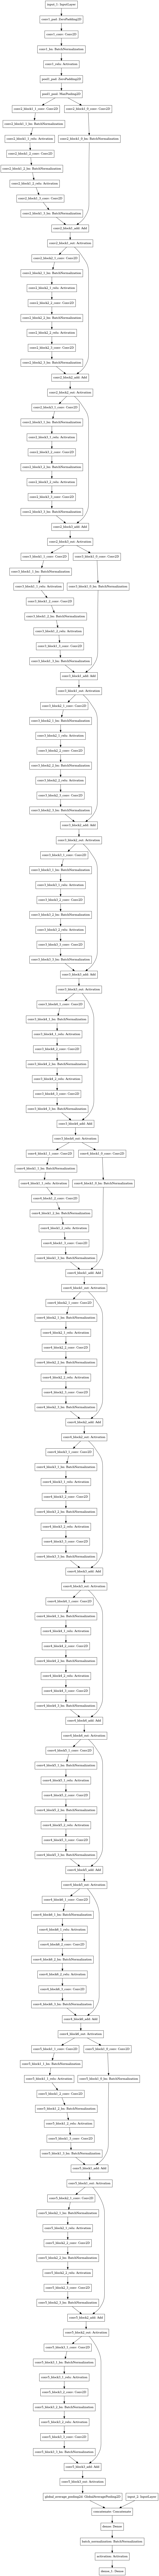

In [9]:
plot_model(model)

In [10]:
train_datagen = image.ImageDataGenerator(
    rescale=1/255,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True
    )

val_datagen = image.ImageDataGenerator(
    rescale=1/255,
    )
EPOCH = 2
BATCH = 64

early_stopping =  EarlyStopping(
                            monitor='val_loss',
                            min_delta=5.0,
                            patience=20,
)

log = model.fit(
    x = gen_flow_for_two_inputs(train_datagen, BATCH, train_meta),
    steps_per_epoch = np.ceil(train_meta.shape[0] / BATCH),
    validation_data = gen_flow_for_two_inputs(val_datagen, BATCH, valid_meta),
    validation_steps = np.ceil(valid_meta.shape[0] / BATCH),
    epochs = EPOCH,
    callbacks=[early_stopping]
    )

Found 7929 validated image filenames.


2021-11-15 10:23:40.388583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2021-11-15 10:23:47.089272: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


124/124 [==============================] - 242s 2s/step - loss: 1508.4803 - mse: 1508.4803 - val_loss: 1224.4836 - val_mse: 1224.4836
Epoch 2/2
124/124 [==============================] - 195s 2s/step - loss: 943.9277 - mse: 943.9277 - val_loss: 868.6091 - val_mse: 868.6091


In [11]:
#save the trainend model
model.save('resnet_multi_3.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


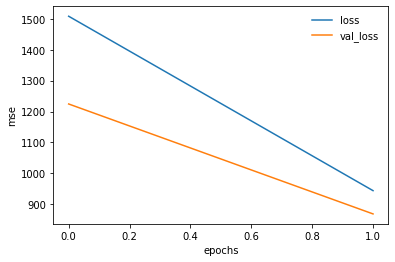

In [12]:
# show history
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) 
plt.xlabel("epochs")
plt.ylabel("mse")
plt.show()

In [13]:
#prediction
test_datagen = image.ImageDataGenerator(
    rescale=1/255,
    )

BATCH = 32

test_meta = pd.read_csv(test_csv_path)
def make_full_path_test(id):
    return os.path.join(comp_path, 'test', id+'.jpg')
test_meta['Id2'] = test_meta['Id'].apply(make_full_path_test)

# Generator for 2 input
def gen_flow_for_two_inputs_test(datagen, batch, x_train, shuffle=True):
    """
    Args:
        datagen(image.ImageDataGenerator): data generator
        batch(int): batch size 
        x_train: dataframe for input img and metadata
        y_train(np.ndarray): label array for output 
        shuffle(bool): bool to shuffle data
    """
    # Pass index to the 2nd parameter instead of labels
    x_train_2 = x_train.set_index('Id')
    batch = datagen.flow_from_dataframe(x_train, batch_size=batch, shuffle=shuffle, 
                                        x_col='Id2', y_col='Id', class_mode = 'raw',
                                        target_size=(224, 224))
    while True:
        batch_image, batch_index = batch.next()
        # Use index values for text(x_text) and labels(y_train)
        yield [batch_image, 
               x_train_2.loc[batch_index, 
                           ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 
                            'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']].values], np.zeros(1)

pred = model.predict_generator(
    generator = gen_flow_for_two_inputs_test(test_datagen, BATCH, test_meta, shuffle=False), verbose= 1,
    steps = np.ceil(test_meta.shape[0] / BATCH)
    )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 8 validated image filenames.
1/1 [==============================] - 1s 948ms/step


In [14]:
#save the submission file
test_meta['Pawpularity'] = pred 
submission_df = test_meta[['Id','Pawpularity']]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,17.357006
1,43a2262d7738e3d420d453815151079e,17.580830
2,4e429cead1848a298432a0acad014c9d,17.635443
3,80bc3ccafcc51b66303c2c263aa38486,17.449400
4,8f49844c382931444e68dffbe20228f4,17.515753
